In [3]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))
figdir = os.path.join(os.path.pardir, 'figures')
savedir = os.path.join(os.path.pardir, 'simulation_data')

import numpy as np
import numpy.matlib
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import itertools
import control
import pickle
import figurefirst as fifi

import figure_functions as ff
from simulator import LinearSystemSimulator
from observability import ObservabilityMatrix
from eiso import optimize_matrix_rows_to_state, optimize_matrix_rows_to_states, optimize_matrix_rows_to_states_iterative
from eiso import analytical_observability_gramian, calculate_condition_number, rank_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [4]:
path_const_wind_const_vel_no_control = os.path.join(savedir, 'control_none_output_phi_gamma_of.pk')
path_const_wind_phi_control = os.path.join(savedir, 'control_phi_output_phi_gamma_of.pk')
path_const_wind_vel_control = os.path.join(savedir, 'control_v_output_phi_gamma_of.pk')

path_const_wind_vel_phi_control_output_phi_gamma = os.path.join(savedir, 'control_phi_v_output_phi_gamma.pk')
path_const_wind_vel_phi_control_output_phi_gamma_of = os.path.join(savedir, 'control_phi_v_output_phi_gamma_of.pk')

with open(path_const_wind_const_vel_no_control, 'rb') as fp:
    const_wind_const_vel_no_control = pickle.load(fp)
    
with open(path_const_wind_vel_control, 'rb') as fp:
    const_wind_vel_control = pickle.load(fp)

with open(path_const_wind_phi_control, 'rb') as fp:
    const_wind_phi_control = pickle.load(fp)
    
with open(path_const_wind_vel_phi_control_output_phi_gamma, 'rb') as fp:
    const_wind_vel_phi_control_output_phi_gamma = pickle.load(fp)
    
with open(path_const_wind_vel_phi_control_output_phi_gamma_of, 'rb') as fp:
    const_wind_vel_phi_control_output_phi_gamma_of = pickle.load(fp)

# print(const_wind_const_vel_no_control.keys())
print('Loading done')

Loading done


### Collect data for figure

In [5]:
data_selection = [const_wind_vel_phi_control_output_phi_gamma, const_wind_vel_phi_control_output_phi_gamma_of]

data_trajectory = [const_wind_const_vel_no_control, const_wind_phi_control, const_wind_vel_control, data_selection[1]]

data_all = data_selection + data_trajectory[:-1]

# data_trajectory = [const_wind_const_vel_no_control, const_wind_phi_control, const_wind_vel_control,
#                    const_wind_vel_phi_control_output_phi_gamma, const_wind_vel_phi_control_output_phi_gamma_of]

n_trajectory = len(data_trajectory)

obsv_metric = 'CN_iter_over_time'

### Observability color function

In [6]:
def get_color(obsv_metric):
    color = obsv_metric
    return color

### Set colormap & normalize color range

In [7]:
# Make colormaps
crange = 0.7
cmapname = 'RdPu'

cmap = cm.get_cmap(cmapname)
cmap = cmap(np.linspace(1-crange, 1, 100))
cmap = ListedColormap(cmap)

cmapr = cm.get_cmap(cmapname + '_r')
cmapr = cmapr(np.linspace(0, crange, 100))
cmapr = ListedColormap(cmapr)

In [8]:
# Set & normalize colors
colormax = []
colormin = []
for d in data_all:
    c = get_color(d[obsv_metric])
    colormax.append(np.nanmax(c))
    colormin.append(np.nanmin(c))

colormax = max(colormax)
colormin = min(colormin)

In [9]:
colormax

578308.6966424633

In [10]:
colormin

1.0

### Set sensor selection subplot color based on observability

In [11]:
s1 = pd.DataFrame(get_color(data_selection[0][obsv_metric]))
s2 = pd.DataFrame(get_color(data_selection[1][obsv_metric]))

# Choose when to switch to sensor 2
switch_index = 33
s_comb = s1.copy(deep=True)
s_comb.iloc[switch_index:, :] = s2.iloc[switch_index:, :]

### State trajectory plot

In [12]:
text_color = 'black'
back_color = 'white'
u_colors = ['darkgray', 'deepskyblue']

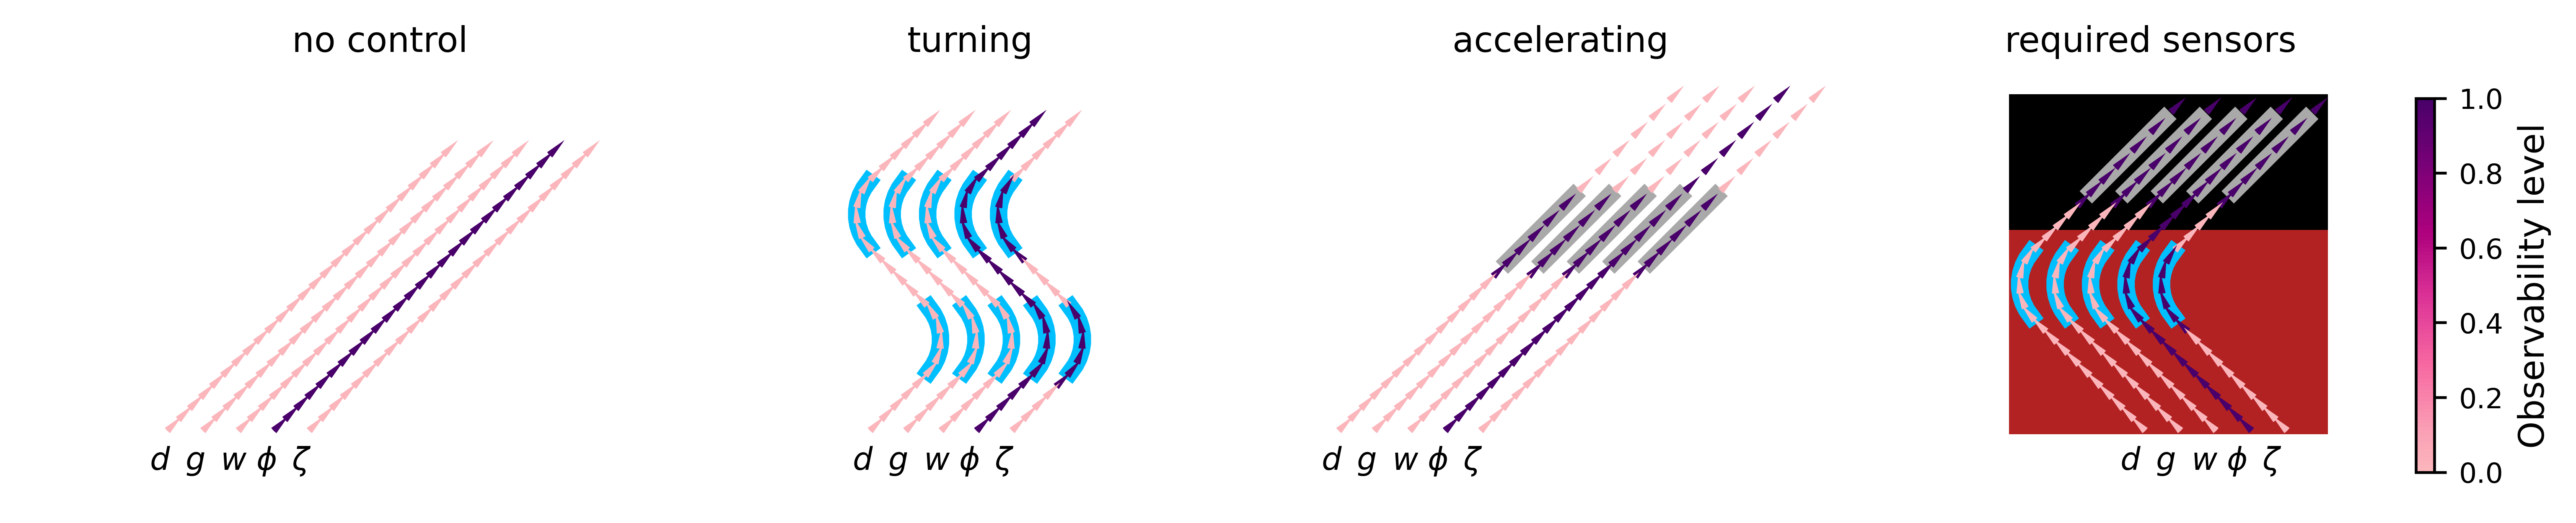

In [13]:
fig, ax = plt.subplots(1, n_trajectory, figsize=(3*n_trajectory, 3), dpi=600, facecolor=back_color)
        
arrow_size_res = 1
size_radius = 3
xoff = 5
yoff = 0

data_labels = ['no control', 'turning', 'accelerating', 'required sensors']
state_labels = [r'$d$', r'$g$', r'$w$', r'$\phi$', r'$\zeta$']

ubar = 2
# u_colors = ['cyan', 'cyan']
# u_colors = ['yellow', 'yellow']

cnorm = (colormin, colormax)
for n, d in enumerate(data_trajectory):
    n_state = d['sim_data']['x'].shape[1]
    n_input = d['sim_data']['u'].shape[1]
    
    xpos = d['sim_data']['pos_x']
    ypos = d['sim_data']['pos_y']
    theta = d['sim_data']['phi']
    
    if n < (n_trajectory - 1):
        cvar = get_color(d[obsv_metric])
    else:
        cvar = s_comb.to_numpy()
        
        yswitch = ypos[switch_index]
        xs = [-10, 35]
        
        y1 = [-1, -1]
        y2 = [yswitch, yswitch]
        ax[n].fill_between(xs, y1, y2,
                           color='firebrick',
                           edgecolor='none',
                           alpha=1)
        
        y1 = [2 + np.max(ypos), 2 + np.max(ypos)]
        y2 = [yswitch, yswitch]
        ax[n].fill_between(xs, y1, y2,
                           color='black',
                           edgecolor='none',
                           alpha=1)
        
    cvar = np.nan_to_num(cvar, nan=1.0*colormax)       
    for s in range(n_state):        
        # Interpolate color (only required if slidng window resolution greater than sampling frequency)
        cvar_state = scipy.interpolate.griddata(d['Oe_sliding_time'],
                                                cvar[:,s],
                                                d['sim_data']['time'],
                                                method='nearest')
        
        xshift = xpos - np.mean(xpos) + xoff*s
        yshift = ypos + yoff*s

        # Show when the controls are on
        usim = d['sim_data']['u']
        u_bool = np.abs(usim) > 0
        for u in range(u_bool.shape[1]): # each control
            if np.any(u_bool[:, u], axis=0): # if control was ever used
                onI = u_bool[:, u] # when control was on
                tu = d['sim_data']['time'][onI]
                xu = xshift[onI]
                yu = yshift[onI]
                
                # Plot line only where control was on
                dt = np.diff(tu)
                split = np.where(dt > 0.101)[0] + 1
                tu = np.split(tu, split)
                xu = np.split(xu, split)
                yu = np.split(yu, split)
                
                for p in range(len(xu)):
                    ax[n].plot(xu[p], yu[p], color=u_colors[u], lw=5, alpha=1, zorder=1)
        
        # Show the trajectory with color as the observability metric
        ff.plot_trajectory(xshift,
                           yshift,
                           theta,
                           color=cvar_state,
                           ax=ax[n],
                           size_radius=size_radius,
                           nskip=1,
                           colormap=cmapr,
                           colornorm=cnorm)
        
        # Label each state
        ax[n].text(xshift[0] - 3, yshift[0] - 6, state_labels[s], fontsize=9, weight='bold', color=text_color)
        
    ax[n].set_title(data_labels[n], fontsize=10, color=text_color)
    ax[n].set(aspect=1, xlim=(-30, 50), ylim=(-10, 50))
    ax[n].set_facecolor(back_color)
    ax[n].set_xticklabels([])
    ax[n].set_yticklabels([])
    
    fifi.mpl_functions.adjust_spines(ax[n], [])

# Color bar
cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, fraction=0.008, pad=0.04)
cbar.outline.set_edgecolor(text_color)
cbar.set_label('Observability level', color=text_color, fontsize=10)
cbar.ax.yaxis.set_tick_params(color=text_color, labelsize=8)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=text_color)

plt.subplots_adjust(wspace=0.04)

figpath = os.path.join(figdir, r'figure_3.pdf')
plt.savefig(figpath, bbox_inches='tight')